In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score


# data_dir = "/kaggle/input/cbbl-recruitment-semester-2-regression"
data_dir = "."
random_state = 42

: 

# Data Processing

In [ ]:
train_df = pd.read_csv(f"{data_dir}/train.csv")
train_df

((1775, 20), (1775,))

In [4]:
test_df = pd.read_csv(f"{data_dir}/test.csv")
X_test = test_df.iloc[:, 1:]
X_test

,Material,Type,Shape,Coat/Functional Group,Synthesis_Method,Surface_Charge,Cell_Type,No_of_Cells (cells/well),Human_Animal,Cell_Source,Cell_Tissue,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Size,Zeta
0,Ag,I,Sphere,Citrate,Commercial,Negative,CCL-110,5000,H,Human,Skin,Fibroblast,Fetus,P,24,0.50,MTS,TetrazoliumSalt,39.94,-23.5
1,Chitosan,O,Irregular,NaN,Ionotropic Gelation Method,Positive,MBMC,10000,A,Mouse,BoneMarrow,Spindle,Adult,P,72,31.25,MTT,TetrazoliumSalt,475.20,71.3
2,NiO,I,Sphere,NaN,Commercial,Positive,HepG2,10000,H,Human,Liver,Epithelial,Adult,L,24,100.00,MTS,TetrazoliumSalt,21.60,25.3
3,TiO2,I,Sphere,NaN,Commercial,Negative,A549,30000,H,Human,Lung,Epithelial,Adult,L,48,10.00,MTT,TetrazoliumSalt,81.80,-8.6
4,Chitosan,O,Irregular,NaN,Ionotropic Gelation Method,Positive,MBMC,10000,A,Mouse,BoneMarrow,Spindle,Adult,P,24,1000.00,MTT,TetrazoliumSalt,384.60,62.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Au,I,Sphere,CYS,Chemical Reduction,Negative,L929,5000,A,Mouse,SubcutaneousConnectiveTissue,Fibroblast,Adult,L,24,5.00,MTT,TetrazoliumSalt,25.76,-46.8
758,MWCNT,C,Nanotube,NaN,Commercial,Neutral,HUVEC,40000,H,Human,Umbilical Vein,Endothelial,Embryonic,P,24,32.00,NRU,NeutralRed,17.60,0.9
759,PLGA,O,Sphere,Chitosan,Emulsion-Solvent Evaporation,Positive,Colo_205,10000,H,Human,Colon,Epithelial,Adult,L,24,1250.00,MTS,TetrazoliumSalt,204.00,10.0
760,C60,C,Sphere,Dextran,Commercial,Negative,C6,10000,A,Rat,Brain,Fibroblast,Adult,L,24,25.00,MTT,TetrazoliumSalt,30.00,-16.9


## Data Cleaning

In [5]:
def plot_distribution(data, column, title) -> None:

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Distribution of {title}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=column, data=data)
    plt.title(f"Boxplot of {title}")
    plt.xlabel("Coat/Functional Group")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def handle_outliers(data, column, method) -> pd.DataFrame:
    """
    Handles outliers in the specified column using the given method.
    """
    if method == "drop":
        return data[data[column].between(data[column].quantile(0.05), data[column].quantile(0.95))]
    elif method == "clip":
        Q1 = train_df["Target"].quantile(0.25)
        Q3 = train_df["Target"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[column] = data[column].clip(lower_bound, upper_bound)
        return data
    elif method == "zscore":
        z_scores = (data[column] - data[column].mean()) / data[column].std()
        return data[(z_scores > -3) & (z_scores < 3)]
    else:
        raise ValueError("Invalid outlier handling method specified.")

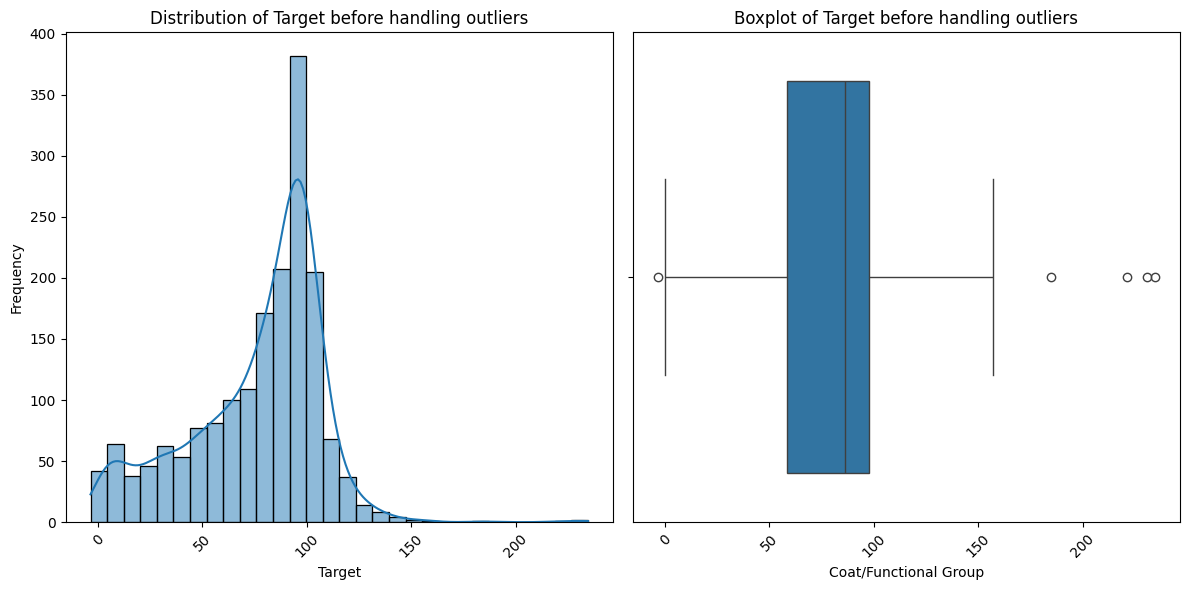

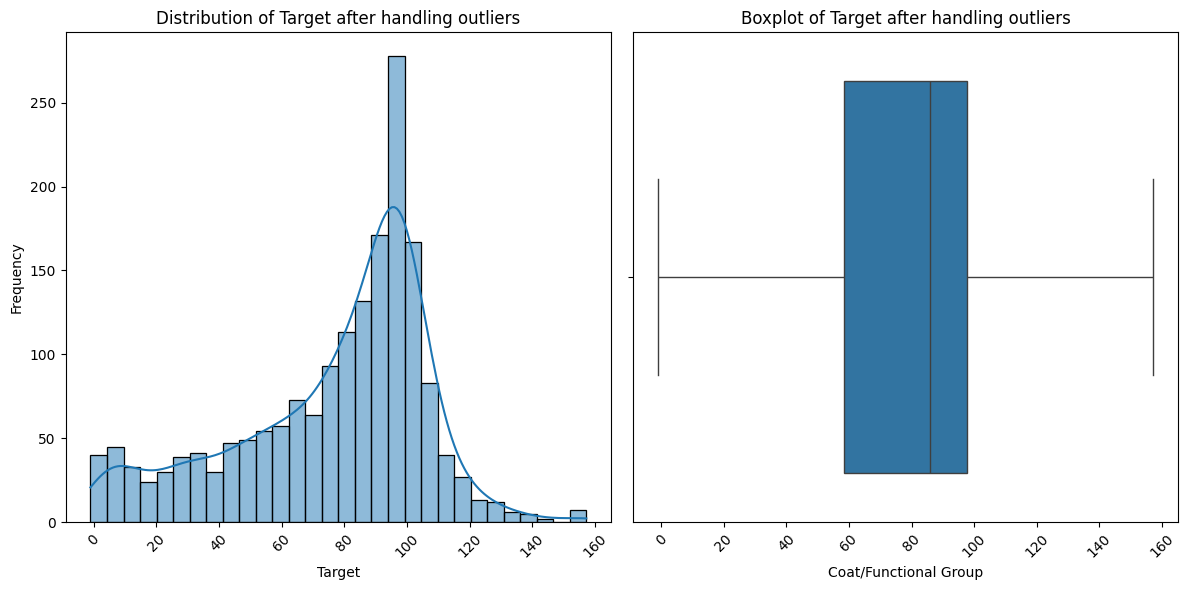

,ID,Material,Type,Shape,Coat/Functional Group,Synthesis_Method,Surface_Charge,Cell_Type,No_of_Cells (cells/well),Human_Animal,...,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Size,Zeta,Target
0,472,Pt,I,Sphere,PVP,Chemical Reduction,Negative,IMR90,5000.0,H,...,Fibroblast,Adult,L,24,25.0,CellTiterGlo,LuciferaseEnzyme,4.00,-8.00,98.293
1,232,Au,I,Sphere,CYS,Chemical Reduction,Negative,L929,5000.0,A,...,Fibroblast,Adult,L,24,50.0,MTT,TetrazoliumSalt,25.76,-46.80,90.476
2,2041,EudragitRL,O,Sphere,NaN,Emulsion-Solvent Evaporation,Positive,THP-1,5000.0,H,...,Monocyte,Adult,L,24,25.0,MTT,TetrazoliumSalt,142.00,56.00,123.470
3,437,Au,I,Sphere,Citrate,Chemical Reduction,Negative,Jurkat,500000.0,H,...,Lymphoblast,Adult,L,24,1.5,MTT,TetrazoliumSalt,7.00,-99.00,89.391
4,68,SLN,O,Sphere,NaN,Emulsion-Solvent Evaporation,Negative,A549,100000.0,H,...,Epithelial,Adult,L,24,3671.1,NRU,TetrazoliumSalt,98.40,-14.60,29.601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,611,Dendrimer,O,Sphere,C12,Commercial,Positive,hNPC,100000.0,H,...,Neuronal,Embryonic,P,72,1.0,MTT,TetrazoliumSalt,4.50,54.47,110.620
1771,479,ZnO,I,Sphere,NaN,Commercial,Positive,HCMEC,50000.0,H,...,Epithelial,Adult,P,12,0.1,MTT,TetrazoliumSalt,45.30,32.70,100.330
1772,732,C70,C,Sphere,NaN,Commercial,Negative,V79,10000.0,A,...,Fibroblast,Adult,L,24,5.0,MTT,TetrazoliumSalt,57.00,-35.00,92.898
1773,1184,Polystyrene,O,Sphere,COOH,Commercial,Negative,HeLa,5000.0,H,...,Epithelial,Adult,L,48,5.0,CCK-8,TetrazoliumSalt,50.00,-9.00,105.980


In [6]:
# Plotting the distribution of the Target column in Histogram and Boxplot before handling outliers
plot_distribution(train_df, "Target", "Target before handling outliers")

# Using the most frequent category for 'Target' as a simple handling outliers") method.
train_df = handle_outliers(train_df, "Target", "clip")

# Plotting the distribution of the Target column in Histogram and Boxplot after handling outliers.
plot_distribution(train_df, "Target", "Target after handling outliers")

train_df

In [7]:
X_train, y_train = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]
X_train.shape, y_train.shape

((1775, 20), (1775,))

## Feature Encoding

In [ ]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
encoder = LabelEncoder()

for cols in cat_cols:
    X_train[cols] = encoder.fit_transform(X_train[cols])
    X_test[cols] = encoder.transform(X_test[cols])

In [9]:
X_train

,Material,Type,Shape,Coat/Functional Group,Synthesis_Method,Surface_Charge,Cell_Type,No_of_Cells (cells/well),Human_Animal,Cell_Source,Cell_Tissue,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Size,Zeta
0,20,1,6,23,1,0,26,5000.0,1,2,15,2,0,0,24,25.0,3,4,4.00,-8.00
1,2,1,6,4,1,0,31,5000.0,0,4,22,2,0,0,24,50.0,8,7,25.76,-46.80
2,11,2,6,31,6,2,46,5000.0,1,2,2,7,0,0,24,25.0,8,7,142.00,56.00
3,2,1,6,6,1,0,28,500000.0,1,2,2,5,0,0,24,1.5,8,7,7.00,-99.00
4,21,2,6,31,6,0,4,100000.0,1,2,15,1,0,0,24,3671.1,9,7,98.40,-14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,9,2,6,1,4,2,53,100000.0,1,2,4,10,1,1,72,1.0,8,7,4.50,54.47
1771,25,1,6,31,4,2,14,50000.0,1,2,12,1,0,1,12,0.1,8,7,45.30,32.70
1772,4,0,6,31,4,0,49,10000.0,0,1,15,2,0,0,24,5.0,8,7,57.00,-35.00
1773,19,2,6,2,4,0,24,5000.0,1,2,6,1,0,0,48,5.0,1,7,50.00,-9.00


In [10]:
X_test

,Material,Type,Shape,Coat/Functional Group,Synthesis_Method,Surface_Charge,Cell_Type,No_of_Cells (cells/well),Human_Animal,Cell_Source,Cell_Tissue,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Size,Zeta
0,0,1,6,6,4,0,10,5000,1,2,20,2,2,1,24,0.50,7,7,39.94,-23.5
1,6,2,2,31,11,2,32,10000,0,4,3,11,0,1,72,31.25,8,7,475.20,71.3
2,16,1,6,31,4,2,25,10000,1,2,14,1,0,0,24,100.00,7,7,21.60,25.3
3,24,1,6,31,4,0,4,30000,1,2,15,1,0,0,48,10.00,8,7,81.80,-8.6
4,6,2,2,31,11,2,32,10000,0,4,3,11,0,1,24,1000.00,8,7,384.60,62.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2,1,6,4,1,0,31,5000,0,4,22,2,0,0,24,5.00,8,7,25.76,-46.8
758,14,0,3,31,4,1,22,40000,1,2,24,0,1,1,24,32.00,9,5,17.60,0.9
759,17,2,6,5,6,2,13,10000,1,2,7,1,0,0,24,1250.00,7,7,204.00,10.0
760,3,0,6,12,4,0,9,10000,0,5,4,2,0,0,24,25.00,8,7,30.00,-16.9


# Model Training

In [11]:
model = GradientBoostingRegressor(
    random_state=random_state,
    loss="squared_error",
    learning_rate=0.2,
    n_estimators=200,
    subsample=0.8,
    criterion="squared_error",
    max_depth=7,
    max_features="sqrt",
    min_samples_split=5,
    min_samples_leaf=2,
)
model.fit(X_train, y_train)

print("Training R2 Score: ", r2_score(y_train, model.predict(X_train)))

Training R2 Score:  0.9839968467014045


# Model Optimization

In [11]:
param_grid = {
    "loss": ["squared_error", "huber", "quantile"],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1.0],
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "max_depth": [3, 5, 7],
    "random_state": [random_state],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',
    n_jobs=-1,
    cv=5,
    verbose=2,
)

In [12]:
grid_search.fit(X_train, y_train)

best_model_class = grid_search.best_estimator_
best_score_class = grid_search.best_score_
print(f"Best Model Hyperparameters: {grid_search.best_params_}")
print(f"Best Model Score (R2): {best_score_class}")

# Store the best models (optional, but good practice)
# You can save these models using joblib or pickle
# Example using joblib:
# import joblib
# joblib.dump(best_model_class, 'best_random_forest_classifier.pkl')

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best Model Hyperparameters: {'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}
Best Model Score (R2): 0.8253797376363796


# Model Evaluation

In [ ]:
result_df = pd.DataFrame(data={"ID": test_df.iloc[:, 0], "Target": model.predict(X_test)})
result_df.to_csv("submission.csv", index=False)

# !head submission.csv